In [53]:
from collections import Counter, defaultdict
import os
from glob import glob
import numpy as np
import cv2
from tqdm.notebook import tqdm

# Set the path to the images that are to be used for creating the counters (per magnification and target)
all_paths = glob(os.path.join("../../data/03_training_data/normalized_bias/train/targets", "*/Assay*"))

def create_counters(paths):
    magnifications = ["20x", "40x", "60x"]
    targets = ["A01", "A02", "A03"]
    general_histograms = defaultdict(lambda: defaultdict(Counter))
    for path in tqdm(paths):
        for mag in magnifications:
            for target in targets:
                if mag in path and target in path:
                    img = np.array(cv2.imread(path, -1))
                    count = Counter(list(img.ravel()))
                    general_histograms[mag][target] += count
    return general_histograms

gh = create_counters(all_paths)

In [87]:
all_20 = [path for path in all_paths if "20x" in path]
all_40 = [path for path in all_paths if "40x" in path]
all_60 = [path for path in all_paths if "60x" in path]
one_each = [all_20[0],all_40[0],all_60[0]]

sizes = [np.asarray(cv2.imread(path,-1)).shape for path in one_each]
reference_sizes = {"20x":sizes[0][0]*sizes[0][1], "40x":sizes[1][0]*sizes[1][1], "60x":sizes[2][0]*sizes[1][1]}
print(reference_sizes)

{'20x': 5501316, '40x': 5510736, '60x': 5510736}


In [54]:
# Find the normalizing factors for the counter objects
magnifications = ["20x", "40x", "60x"]
targets = ["A01", "A02", "A03"]
norm_coeffs = defaultdict(lambda: defaultdict(int))
for path in tqdm(all_paths):
    for mag in magnifications:
        for target in targets:
            if mag in path and target in path:
                norm_coeffs[mag][target] += 1
    


In [ ]:
!mkdir ../../data/06_outputs/target_counters

In [108]:
normalized_histograms = defaultdict(lambda: defaultdict(Counter))
import pickle
import random


for mag in gh.keys():
    for target in gh[mag].keys():
        c_keys = list(gh[mag][target].keys())
        c_vals = [round(x/norm_coeffs[mag][target]) for x in list(gh[mag][target].values())]
        ref_size = reference_sizes[mag]
        # make sure that the size is correct for later generation of images from
        # these counters. adding 1 to random values
        if sum(c_vals) < ref_size:
            k = ref_size-sum(c_vals)
            random_indices = random.choices([i for i in range(len(c_vals))], k = k)
            for index in random_indices:
                c_vals[index] +=1
        d = dict(zip(c_keys, c_vals))
        with open('../../data/06_outputs/target_counters/counter_objects_' + 
                  mag + '_' + target+ '.pickle', 'wb') as handle:
            pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)


<AxesSubplot:ylabel='Density'>

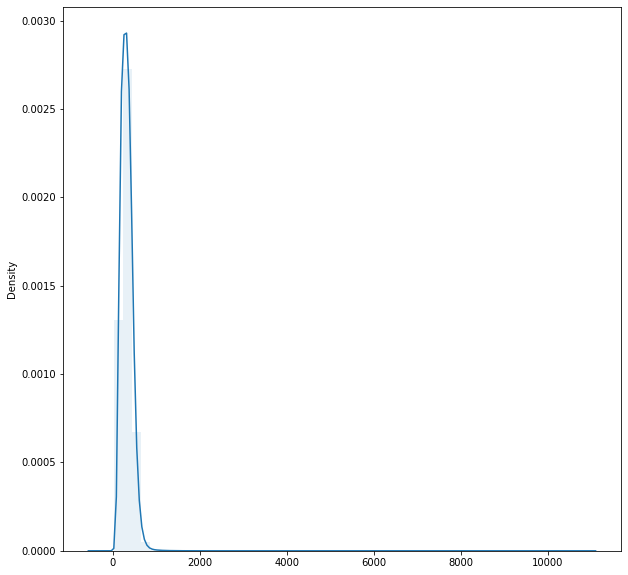

In [94]:
# short visualisation to make sure the dicts look alright
import matplotlib.pyplot as plt
! pip install seaborn
import seaborn as sns

fig, axs = plt.subplots(1,1,figsize=(10,10))
sns.distplot(list(d.keys()), ax = axs,
                    hist_kws={"weights":list(d.values()), "alpha": 0.1}, 
                    kde_kws = {"weights":list(d.values()), "label" : "predicted"})

['../../data/04_generated_images/20x_images/AssayPlate_Greiner_#655090_B04_T0001F006L01A01Z01C01.tif', '../../data/04_generated_images/40x_images/AssayPlate_Greiner_#655090_B03_T0001F008L01A03Z01C03.tif', '../../data/04_generated_images/60x_images/AssayPlate_Greiner_#655090_B04_T0001F009L01A01Z01C01.tif']
(2154, 2554)
(2154, 2554)


/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


tensor([[251.2241, 357.8109, 373.0109,  ..., 296.3030, 298.9248, 223.5281],
        [357.8109, 448.8627, 443.2240,  ..., 318.5157, 340.4605, 298.9248],
        [361.4872, 437.6895, 432.2990,  ..., 301.5880, 321.5118, 293.7135],
        ...,
        [347.1647, 412.2813, 402.9173,  ..., 229.7853, 246.8249, 271.6032],
        [343.7726, 432.2990, 422.0196,  ..., 244.6564, 264.6449, 273.9495],
        [246.8249, 340.4605, 347.1647,  ..., 257.8495, 266.9539, 219.3648]])

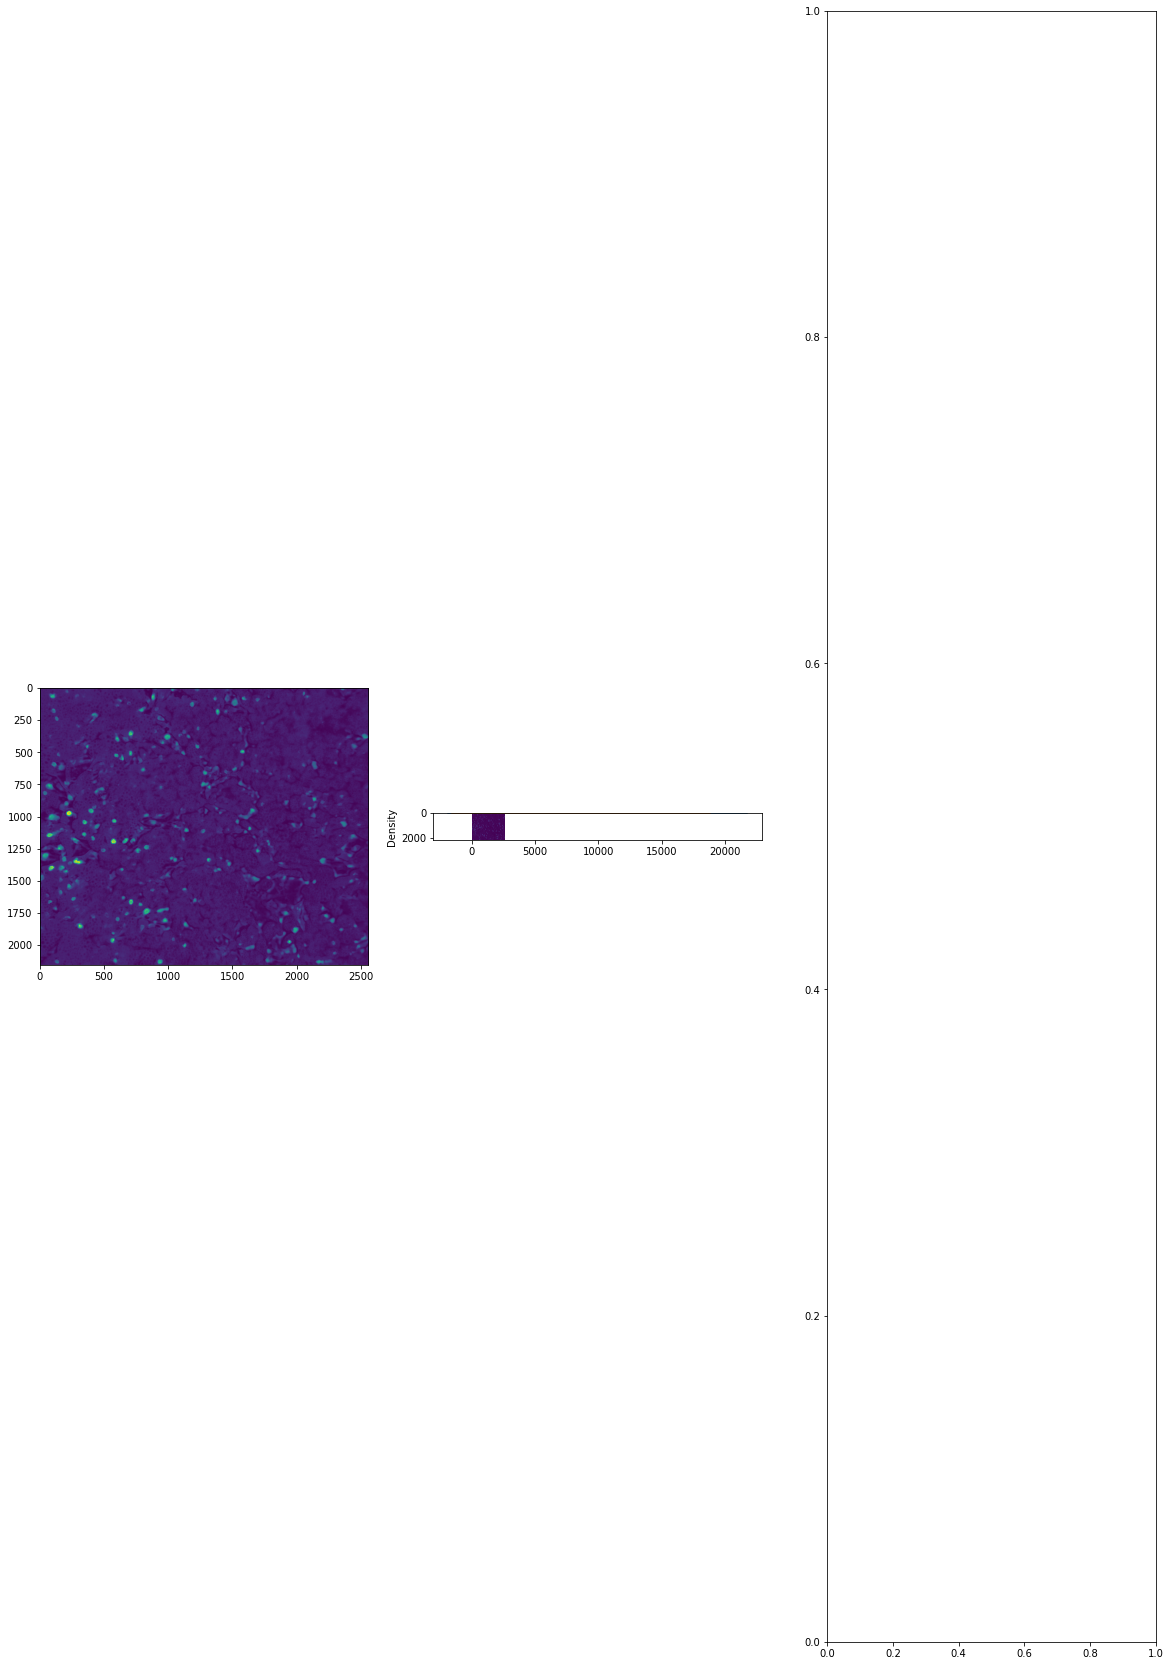

In [127]:


generated_paths = glob(os.path.join("../../data/04_generated_images", "*/Assay*"))
all_20 = [path for path in generated_paths if "20x" in path]
all_40 = [path for path in generated_paths if "40x" in path]
all_60 = [path for path in generated_paths if "60x" in path]
one_each = [all_20[0],all_40[0],all_60[0]]
print(one_each)

torch_tensors_gen = [torch.Tensor(cv2.imread(path,-1).astype(np.int)) for path in one_each]

import torch
from skimage.exposure import match_histograms
import numpy as np 
import cv2
import pickle

def matching_histograms(gen_img : torch.Tensor, mag : str, target : str) -> torch.Tensor:
        gen_img_np = gen_img.numpy()
        print(gen_img_np.shape)
        
        with open('../../data/06_outputs/target_counters/counter_objects_' + 
                  mag + '_' + target+ '.pickle', 'rb') as handle:
            counter = pickle.load(handle)
        reference_img = []
        for key, val in counter.items():
            reference_img.extend([key for i in range(val)])
        reference_img = np.reshape(np.asarray(reference_img), gen_img_np.shape)
        matched = match_histograms(gen_img_np, reference_img)
        print(matched.shape)
        fig, axs = plt.subplots(1,3, figsize=(20,30))
        axs[0].imshow(gen_img_np)
        axs[1].imshow(matched)
        sns.distplot(list(counter.keys()), ax = axs[1],
                    hist_kws={"weights":list(counter.values()), "alpha": 0.1}, 
                    kde_kws = {"weights":list(counter.values()), "label" : "reference"})
        counter2 = Counter(list(matched.ravel()))
        sns.distplot(list(counter2.keys()), ax = axs[1],
                    hist_kws={"weights":list(counter2.values()), "alpha": 0.1}, 
                    kde_kws = {"weights":list(counter2.values()), "label" : "reference"})
        return torch.Tensor(matched)
    
matching_histograms(torch_tensors_gen[0], "20x", "A01")